##### Testing code

# Ablation study - thesis results generation

#### Imports


In [4]:
# Import all of the requried libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import statistics
from scipy import interpolate
import os
import os.path
import json

from scipy import signal
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# import the sklearn metrics
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# Add the balanced accurcy score balanced_accuracy_score
from sklearn.metrics import balanced_accuracy_score
import seaborn as sns

from plotly import express as px
import plotly.graph_objects as go

from imblearn.over_sampling import RandomOverSampler as ros
from imblearn.over_sampling import SMOTE as smote
from collections import Counter

import itertools

# These are all of the libraries that I manually created
# import Processfunctions as process


# Through 3D slicer
# start_index = 0 # starts at 195nm
# start_index = 742 # starts at 350nm
start_index = 790 # starts at 360nm
# start_index = 1070 # starts at 420nm

# print pandas version
print(pd.__version__)

2.0.0


#### Functions

##### Data loading functions

In [5]:
def loadSpectrum(path, col_name=None,start_index=774,end_index=-1,sep=';'):
#     df = pd.read_csv(path + name,sep=';',engine='python')
    df = pd.read_csv(path,sep=sep,engine='python')
#     print(df)
    if not(col_name == None):
        df[col_name] = df.index
    data = df[start_index:end_index]
#     print(data)
    data_arr = data.to_numpy()
    data_arr = np.array(data_arr,dtype='float')
    return data_arr

##### Processing functions

In [ ]:
# Normalize peak instensity to 1.0
def normalize(data):
    temp = data.copy()
    if len(temp.shape) == 2:
        temp[:,1] = (temp[:,1] - min(temp[:,1]))
        temp[:,1] = temp[:,1]/max(temp[:,1])
    elif len(temp.shape) == 3:
        for i in range(len(temp)):
            temp[i,:,1] = (temp[i,:,1] - min(temp[i,:,1]))
            temp[i,:,1] = temp[i,:,1]/max(temp[i,:,1])
    else:
        print('Error, array dimension is not 2 or 3')     
    return temp

In [6]:
def divTfuc(inputData,tFunc):    
    outputData = inputData.copy()
    # For each spectra
    for i in range (inputData[:,:,1].shape[0]):
        data = inputData[i,:,1]
        # Divide by the baseline transfer function
        outputData[i,:,1] = data / tFunc 
    outputData = normalize(outputData)
    return outputData



In [7]:
def removeAmbientLight_method2(Dataset_df, baseline_df, RESOLUTION = 'dataset'):
    Dataset = []
    # average the baseline ambient light
    mean_ambient_baseline = np.mean(baseline_df['Baseline Ambient Light'].tolist(),axis=0)
    # average the baseline ratio
    mean_ratio_baseline = np.mean(baseline_df['Baseline Ratio'].tolist())

    for i in range(Dataset_df.shape[0]):
        # Get the data
        data = np.array(Dataset_df['Data'].tolist())[i,:,:]
        if RESOLUTION == 'dataset':
            # use the average ambient light and ratio for the entire dataset
            ambient_baseline = mean_ambient_baseline
            ratio_baseline = mean_ratio_baseline
        elif RESOLUTION == 'sampleID':
            # Get the sampleID
            sampleID = Dataset_df['SampleID'][i]
            # Get the label
            label = Dataset_df['Label (numeric)'][i]
            # Find the corresponding baseline ambient light and the baseline ratio
            # Get the row of baseline_df where baseline_df['sampleID'] == sampleID and 
            baseline_sample_row = baseline_df.loc[(baseline_df['SampleID'] == sampleID)]
            # Get the row of baseline_df where baseline_df['Label (numeric)'] == Label (numeric)
            baseline_row = baseline_sample_row.loc[(baseline_sample_row['Label (numeric)'] == label)]
            # if baseline_row is empty give an error
            if baseline_row.empty:
                print("Error: baseline_row is empty")
                break
            # Get the baseline ambient light
            ambient_baseline = np.array(baseline_row['Baseline Ambient Light'].tolist())[0,:,:]
            # Get the baseline ratio
            ratio_baseline = np.array(baseline_row['Baseline Ratio'].tolist())[0]

        # Remove ambient light peak
        data = removeAmbientLight1(data,ambient_baseline,ratio_baseline)
        Dataset.append(data)

    # Return the dataset as an array
    Dataset = np.array(Dataset,dtype='float')
    return Dataset

def removeAmbientLight1(data,ambient_baseline,ratio_baseline):
    # For each signal in dataset, calulate the ratio of the signal to the ambient light
    ratio_data = calcAmbientRatio(data)
    # print("ratio_data",ratio_data)
    # compare to the baseline ratio
    ratio_comparison = (ratio_baseline/ratio_data)
    # scale the ambient light by the comparison ratio
    scaled_ambient = ambient_baseline.copy()
    scaled_ambient[:,1] = scaled_ambient[:,1]/ratio_comparison
    # subtract the scaled ambient light from the signal
    data[:,1] = data[:,1] - scaled_ambient[:,1]
    return data

def calcAmbientRatio(signal):
    # Find the peak ambient light value in the range of 1110 to 1130
    ambient_peak_value = np.max(signal[1110:1130,1])
    # Find the peak signal value in the range of 1200 to 1800
    signal_peak_value = np.max(signal[1200:1800,1])
    # calculate the ratio of the signal to the ambient light
    ratio = signal_peak_value/ambient_peak_value
    return ratio

# data = removeAmbientLight_method2(Dataset_df,ambient_baseline_df) # Method 2: Estimate the ambient light for each scan




In [8]:
def removeAmbientLight_method1(data):
    start_index = 1110
    width = 20
    end_index = start_index + width
    for i in range(len(data)):
        data[i,start_index:end_index,1] = 0
    return data

In [9]:
def preprocessing_pipeline(Dataset_df,ambient_baseline_df, lightsource_output_curve,FLAG_AMBIENT_LIGHT,FLAG_CROP, FLAG_NORMALIZE, FLAG_TFUNC):
    
    # print('Preprocessing Flags:')
    # print('FLAG_AMBIENT_LIGHT:',FLAG_AMBIENT_LIGHT)
    # print('FLAG_CROP:',FLAG_CROP)
    # print('FLAG_NORMALIZE:',FLAG_NORMALIZE)
    # print('FLAG_TFUNC:',FLAG_TFUNC)
    
    # Step 1: Remove ambient light peak method 1 or 2
    # if FLAG_AMBIENT_LIGHT:
    if FLAG_AMBIENT_LIGHT == 1:
        data = np.array(Dataset_df['Data'].tolist())
        data = removeAmbientLight_method1(data) # Method 1: Remove just the peak of the ambient light
    elif FLAG_AMBIENT_LIGHT == 2:
        data = removeAmbientLight_method2(Dataset_df,ambient_baseline_df) # Method 2: Estimate the ambient light for each scan
    else:
        data = np.array(Dataset_df['Data'].tolist())

    # Step 2: Crop the data to 420 nm
    if FLAG_CROP:
        data = data[:,280:,:]
        lightsource_output_curve = lightsource_output_curve[280:,:]
    # print('Data shape after cropping:',lightsource_output_curve[:,1])

    # Step 3: Normalize the data using minimax
    if FLAG_NORMALIZE: 
        data = normalize(data)

    # Step 4: Divide by the baseline transfer function
    if FLAG_TFUNC:
        data = divTfuc(data,lightsource_output_curve[:,1])

    # Step 5: Feature reduction

    processed_data = data.copy()

    # Step 6: Turn the processed data into a singe data column in a dataframe
    data_df = pd.DataFrame()
    for i in range(processed_data.shape[0]):
        new_row = {'Data_preprocessed':processed_data[i,:,:]}
        data_df = pd.concat([data_df, pd.DataFrame([new_row])], ignore_index=True)
    # Add the data to the dataframe
    processedData_df = pd.concat([Dataset_df, data_df], axis=1)
    return processedData_df

##### Modeling fuctions

In [10]:
def resample_data(data, wavelengths, num_points):
    data = data.copy()
    # Compute the number of data points for the desired resolution
    resampled_wavelengths = np.linspace(wavelengths[0], wavelengths[-1], num=num_points)
    # Resample the data to the desired resolution using linear interpolation
    resampled_data = signal.resample(x=data, num=num_points)#, domain='freq')
    return resampled_wavelengths, resampled_data

# train_X = np.array(train_df['Data_preprocessed'].tolist())[:, :, 1]
# test_X = np.array(test_df['Data_preprocessed'].tolist())[:, :, 1]
# # Get the wavelengths for each spectrum
# train_X_wavelengths = np.array(train_df['Data_preprocessed'].tolist())[:, :, 0]
# test_X_wavelengths = np.array(test_df['Data_preprocessed'].tolist())[:, :, 0]
# x,y = resample_data(train_X[1, :], train_X_wavelengths[1, :], num_points=100)

# # Plot the original data
# plt.figure()
# plt.plot(train_X_wavelengths[1, :], train_X[1, :], label='Original')
# # Plot the resampled data
# plt.plot(x, y, label='Resampled')
# plt.legend()
# plt.show()

def bin_data(data, wavelengths, num_bins):
    data = data.copy()
    # Compute the number of data points for the desired resolution
    bin_size = int(len(data)/num_bins)
    # Resample the data to the desired resolution using linear interpolation
    binned_data = np.array([np.mean(data[i*bin_size:(i+1)*bin_size]) for i in range(num_bins)])
    binned_wavelengths = np.array([np.mean(wavelengths[i*bin_size:(i+1)*bin_size]) for i in range(num_bins)])
    return binned_wavelengths, binned_data

# train_X = np.array(train_df['Data_preprocessed'].tolist())[:, :, 1]
# test_X = np.array(test_df['Data_preprocessed'].tolist())[:, :, 1]
# # Get the wavelengths for each spectrum
# train_X_wavelengths = np.array(train_df['Data_preprocessed'].tolist())[:, :, 0]
# test_X_wavelengths = np.array(test_df['Data_preprocessed'].tolist())[:, :, 0]
# x,y = bin_data(train_X[1, :], train_X_wavelengths[1, :], num_bins=100)
# print(y.shape)
# # Plot the original data
# plt.figure()
# plt.plot(train_X_wavelengths[1, :], train_X[1, :], label='Original')
# # Plot the resampled data
# plt.plot(x, y, label='binned')
# plt.legend()
# plt.show()



In [11]:
def oversample_train_data(Train_df,column_name='Data_preprocessed'):
    # Extract train data and labels
    train_X = np.array(Train_df[column_name])
    train_y = np.array(Train_df['Label (numeric)'])
    # reshape for use with ros
    train_X = np.squeeze(np.array(train_X.tolist()))
    # Extract the train data
    # print(train_X.shape)
    if len(train_X.shape) == 3:
        train_X = train_X[:, :, 1]
    elif len(train_X.shape) == 2:
        train_X = train_X

    # print the oversample flag
    if FLAG_OVERSAMPLE:
        overSampler = ros(random_state=42)
        # overSampler = smote(random_state=42)
        train_X_balanced, train_y_balanced = overSampler.fit_resample(train_X, train_y)
    else:
        train_X_balanced = train_X
        train_y_balanced = np.ravel(train_y)
    # print(train_X_balanced.shape)
    return train_X_balanced, train_y_balanced

# train_X_balanced, train_y_balanced = oversample_train_data(train_df)

In [12]:
def fit_LDA(train_df, data_column):
    train_X, train_y = oversample_train_data(train_df,data_column)
    # fit the model
    # lda_classifier = LDA(solver='lsqr', shrinkage='auto')
    # lda_classifier = LDA(solver = 'svd')
    lda_classifier = LDA()
    lda_classifier.fit(train_X, train_y)
    return lda_classifier


In [13]:
def feature_reduction(train_df,test_df,FLAG_FEATURE_REDUCTION_METHOD,reduced_points=100, CM_FLAG = True):
    # CM_FLAG = True
    # print('Feature Reduction Method:',FLAG_FEATURE_REDUCTION_METHOD)
    if FLAG_FEATURE_REDUCTION_METHOD == 'None':
        train_df['Data_reduced'] = train_df['Data_preprocessed']
        test_df['Data_reduced'] = test_df['Data_preprocessed']
        # fit the model
        lda_classifier = fit_LDA(train_df, data_column = 'Data_reduced')
        # evaluate the model
        results_df = evaluate_classifier(testData_df=test_df, classifier=lda_classifier, expName='LDA: Baseline',CM_FLAG=CM_FLAG)
    elif FLAG_FEATURE_REDUCTION_METHOD == 'PCA':
        train_X = np.array(train_df['Data_preprocessed'].tolist())[:, :, 1]
        pca = PCA(n_components=reduced_points)
        pca.fit_transform(train_X)
        # Add the reduced data to the train_df
        train_X_reduced = pca.transform(train_X)
        train_df['Data_reduced'] = [train_X_reduced[i] for i in range(train_X_reduced.shape[0])]
        # Add the reduced data to the test_df
        test_X = np.array(test_df['Data_preprocessed'].tolist())[:, :, 1]
        test_X_reduced = pca.transform(test_X)
        test_df['Data_reduced'] = [test_X_reduced[i] for i in range(test_X_reduced.shape[0])]
        ### Fitting Classifier
        lda = fit_LDA(train_df, data_column='Data_reduced')
        ### Evaluation
        results_df = evaluate_classifier(testData_df=test_df, classifier=lda, data_column = 'Data_reduced', expName='PCA-LDA: 100 components',CM_FLAG=CM_FLAG) 
    elif FLAG_FEATURE_REDUCTION_METHOD == 'Binning':
        train_X = np.array(train_df['Data_preprocessed'].tolist())[:, :, 1]
        test_X = np.array(test_df['Data_preprocessed'].tolist())[:, :, 1]
        # Get the wavelengths for each spectrum
        train_X_wavelengths = np.array(train_df['Data_preprocessed'].tolist())[:, :, 0]
        test_X_wavelengths = np.array(test_df['Data_preprocessed'].tolist())[:, :, 0]

        # Downsample the data to reduced_points points
        # loop through the data and downsample each spectrum
        num_points = reduced_points
        # make an empty array to store the downsampled data
        train_X_reduced = np.zeros((train_X.shape[0], num_points))
        # print('Shape of the train data before downsampling:', train_X.shape[0])
        for i in range(train_X.shape[0]):
            # train_X_reduced[i, :] = resample_data(train_X[i, :], train_X_wavelengths[i, :], num_points=num_points)[1]
            train_X_reduced[i, :] = bin_data(train_X[i, :], train_X_wavelengths[i, :], num_bins=num_points)[1]
        # print('Shape of the data after downsampling:',train_X.shape)
        # Add the reduced data to the train_df
        train_df['Data_reduced'] = [train_X_reduced[i] for i in range(train_X_reduced.shape[0])]
        ### Fitting Classifier
        lda = fit_LDA(train_df, data_column='Data_reduced')
        ### Evaluation
        # Downsample the test set
        
        test_X_wavelengths = np.array(test_df['Data_preprocessed'].tolist())[:, :, 0]
        test_X_reduced = np.zeros((test_X.shape[0], num_points))
        # print('Shape of the test data before downsampling:', test_X.shape)
        for i in range(test_X.shape[0]):
            # test_X_reduced[i, :] = resample_data(test_X[i, :], test_X_wavelengths[i, :], num_points=num_points)[1]
            test_X_reduced[i, :] = bin_data(test_X[i, :], test_X_wavelengths[i, :], num_bins=num_points)[1]
        # add the reduced data to the test_df
        test_df['Data_reduced'] = [test_X_reduced[i] for i in range(test_X_reduced.shape[0])]
        results_df = evaluate_classifier(testData_df=test_df, classifier=lda, data_column='Data_reduced',expName='Binning-LDA: 100 bins',CM_FLAG=CM_FLAG)
    elif FLAG_FEATURE_REDUCTION_METHOD == 'Feature_Selection':
        print('This is no longer a method:',FLAG_FEATURE_REDUCTION_METHOD)
        # # Step 1: Get the train and test data
        # train_X = np.array(train_df['Data_preprocessed'].tolist())[:, :, 1]
        # test_X = np.array(test_df['Data_preprocessed'].tolist())[:, :, 1]
        # # Step 2: Fit the LDA classifier to the data
        # lda_classifier = fit_LDA(train_df, data_column='Data_preprocessed')
        
        # # Step 3: Extract the most discriminative features
        # feature_importances = lda_classifier.coef_[0]
        # # Step 4: Sort the feature importances and select the top reduced_points features
        # num_features = reduced_points
        # # np.argsort(feature_importances) sorts the array feature_importances in ascending order and returns the indices that would sort the array.
        # top_indices = np.argsort(feature_importances)[::-1][:num_features]
        # # top_indices = np.argsort(abs(feature_importances))[::-1][:num_features] % Makes it worse


        # # show an example of the features
        # selected_wavelengths = np.array(processedData_df['Data_preprocessed'].tolist())[0, :, 0][top_indices]
        # selected_features = np.array(processedData_df['Data_preprocessed'].tolist())[0, :, 1][top_indices]

        # # fig = go.Figure(data=go.Scatter(x=selected_wavelengths, y=selected_features, mode='markers'))
        # # fig.update_layout(
        # #     xaxis=dict(title='Wavelength (nm)'),
        # #     yaxis=dict(title='Intensity (a.u.)'),
        # #     title=f'Top {num_features} Selected Wavelengths',
        # #     width=figSize[0],
        # #     height=figSize[1]
        # # )
        # # fig.show()

        # # Step 5: Reduce the train and test data to the selected features
        # train_X_top = np.array(train_df['Data_preprocessed'].tolist())[:, :, 1][:, top_indices]
        # test_X_top = np.array(test_df['Data_preprocessed'].tolist())[:, :, 1][:, top_indices]

        # # Step 5.1 Add the reduced data to the train_df
        # train_df['Data_reduced'] = [train_X_top[i] for i in range(train_X_top.shape[0])]
        # # Step 5.2 Add the reduced data to the test_df
        # test_df['Data_reduced'] = [test_X_top[i] for i in range(test_X_top.shape[0])]

        # # Step 6: Fit the classifier to the reduced data
        # lda_classifier = fit_LDA(train_df,data_column='Data_reduced')

        # # Step 7: Evaluate the classifier on the test set
        # results_df = evaluate_classifier(testData_df=test_df, classifier=lda_classifier, data_column='Data_reduced', expName='LDA: Feature Selection',CM_FLAG=CM_FLAG)
    return results_df

# # feature_reduction(train_df,test_df,FLAG_FEATURE_REDUCTION_METHOD)

In [14]:
def evaluate_classifier(testData_df, classifier, data_column = 'Data_preprocessed',expName='Specify classifier type', average='binary', BY_SAMPLE=False, CM_FLAG=True):
    # print(f'{expName} Results:')
    # print('Evaluating on data column:',data_column)
    # Extract Test data
    if data_column == 'Data_preprocessed':
        test_X = np.array(testData_df['Data_preprocessed'].tolist())[:, :, 1]
    else:
        test_X = np.array(testData_df[data_column].tolist())
    test_y = np.array(testData_df['Label (numeric)'].tolist())
    # print('Shape of the data:',test_X.shape)

    # Evaluate the performance of the classifier on the test data
    y_pred = classifier.predict(test_X)

    # Add the predicted labels to the dataframe
    testData_df['Predicted Label'] = y_pred # I think this is the source of the warning
    # Print the unique predicted labels
    # print('Unique predicted labels:',np.unique(y_pred))

    # Calculate the weighted metrics. This is useful when the classes are imbalanced
    # Accuacy
    accuracy = accuracy_score(test_y, y_pred)
    # Sensitivity
    sensitivity = recall_score(test_y, y_pred, average=average)
    # Specificity
    specificity = precision_score(test_y, y_pred, average=average)
    # Balanced accuracy
    balanced_accuracy = balanced_accuracy_score(test_y, y_pred)
    # F1
    f1 = f1_score(test_y, y_pred, average=average)
    # AUC
    # print('Unique test_y:',np.unique(test_y))
    if len(np.unique(test_y)) != 1:
        auc = roc_auc_score(test_y, y_pred)
    else:
        auc = None

    results_df = pd.DataFrame({'Balanced accuracy':[balanced_accuracy],'Sensitivity':[sensitivity],'Specificity':[specificity],'F1' : [f1], 'AUC': [auc],'Accuracy':[accuracy]}).round({'Value': 2})
    
    if CM_FLAG:
        # display(results_df)
        # Display the overall confusion matrix
        cm = confusion_matrix(test_y, y_pred)
        # show shape of cm
        # print('Confusion Matrix Shape:',cm.shape)
        unique_testy = np.unique(test_y)
        unique_predy = np.unique(y_pred)
        # print('Unique test_y:',unique_testy)
        # print('Unique y_pred:',unique_predy)
        classes = np.unique(np.concatenate((unique_testy,unique_predy)))
        # classes = ['normal', 'cancer']
        # classes = [1,2, 3]
        cm_df = pd.DataFrame(cm, index=classes, columns=classes)
        # display(cm)
        displayCM(cm_df, expName=expName)

    if BY_SAMPLE:
        # Display the confusion matrix broken down by sampleID
        cm_dfs, sampleIDs = cmSampleBreakdown(testData_df)
        for i in range(len(cm_dfs)):
            displayCM(cm_dfs[i], expName=f'{expName}: {sampleIDs[i]}')
    return results_df

def displayCM(cm_df, expName='PCA-LDA'):
    print(cm_df)
    plt.figure()
    # The confusion matrix is a pandas dataframe
    # Calcuate the normalized confusion matrix
    confusion_matrix = cm_df.values
    normalized_matrix = np.round(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis],2)
    # normalized_matrix = confusion_matrix
    # Plot the normalized confusion matrix
    sns.heatmap(normalized_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
    sns.set(font_scale=2)

    # plt.title(f'{expName} Confusion Matrix')
    # update the size of the text
    plt.rcParams.update({'font.size': 25})
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    # Remove the colour bar from the side of the colour bar
    plt.show()

# # create a cm_df
# cm_df = pd.DataFrame([[24,1],[39,87]], index=['0','1'], columns=['0','1'])
# cm_df = pd.DataFrame([[0.000,0.000],[0.0000,112]], index=['0','1'], columns=['0','1'])
# print(cm_df)
# displayCM(cm_df, expName='Test')

In [15]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Create a sample confusion matrix (replace this with your actual data)
# confusion_matrix = np.array([[10, 1],
#                              [20, 200],
#                              ])

# # Calculate the normalized values for each row to represent the darkness of the color
# normalized_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

# # Create a heatmap using Seaborn
# plt.figure(figsize=(8, 6))
# sns.set(font_scale=1.2)
# sns.heatmap(normalized_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
# # edit the values in the confusion matrix



# # Set labels and title
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')

# # Show the plot
# plt.show()


#### Data loader

In [46]:
''' Data loader '''
# Load in the dataset from file
dataset_name = 'KidneyData_march3'
trialPath = "C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03"
# Load in the dataset from file 
file_name = os.path.join(trialPath, dataset_name + '_Formatted_Dataset.csv')
# Load in the dataset
Dataset_df = pd.read_csv(file_name)
# For each Data, convert the string back to an array
Dataset_df['Data'] = Dataset_df['Data'].apply(lambda x: np.array(json.loads(x)))
# print the details of the Dataset_df
print('Dataset_df shape: ', Dataset_df.shape)
display(Dataset_df.head())

# Load in the ambient light baselines dataframe
file_name = os.path.join(trialPath, 'ambient_baseline_and_ratios.csv')
baseline_df = pd.read_csv(file_name)
# For each Data, convert the string back to an array
baseline_df['Baseline Ambient Light'] = baseline_df['Baseline Ambient Light'].apply(lambda x: np.array(json.loads(x)))
baseline_df.shape
baseline_df.head()
ambient_baseline_df = baseline_df.copy()
# display the ambient_baseline_df
display(ambient_baseline_df.head())

# Load in the characteristic light source output
dataPath = "C:/GithubProjects/Spectroscopy_TrackedTissueSensing/data/March2022_raw_data/SLS201L_Spectrum_reformatted.csv"
print(dataPath)
lightsource_output_curve = loadSpectrum(dataPath, 'Wavelength', start_index=10, end_index=675, sep=',')
print(lightsource_output_curve[:,0:2].shape)
# Interpolate such that the downloaded spectrum has the same values of the data
x = lightsource_output_curve[:,0]
y = lightsource_output_curve[:,1]
f = interpolate.interp1d(x,y)
xnew = Dataset_df['Data'][1][:,0]
ynew = f(xnew)
lightsource_output_curve = np.transpose(np.array([xnew,ynew]))
print(lightsource_output_curve.shape)

# # Plot an example of the data
# plt.figure(figsize=(10, 5))
# plt.plot(Dataset_df['Data'][1][:,0], Dataset_df['Data'][1][:,1])
# plt.title('Example of the data')
# plt.xlabel('Wavelength (nm)')

# # Plot an example of the data using plotly
# fig = px.line(x=Dataset_df['Data'][1][:,0], y=Dataset_df['Data'][2][:,1], title='Example of the data')
# fig.update_layout(
#     xaxis_title='Wavelength (nm)', yaxis_title='Signal intensity',
#     xaxis_showgrid=True, xaxis_gridwidth=1, xaxis_gridcolor='lightgrey',
#     yaxis_showgrid=True, yaxis_gridwidth=1, yaxis_gridcolor='lightgrey',
#     plot_bgcolor='white'
# )
# fig.show()

# Add the sample number to the dataframe
Dataset_df['Sample Number'] = Dataset_df['SampleID'].str.extract('(\d+)').astype(int)




Dataset_df shape:  (399, 6)


,PatientID,SampleID,Label (numeric),Label,Data,Time
0,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0055262738350994245], ...",1.677865e+09
1,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0021762760675127974], ...",1.677866e+09
2,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.004287867652463011], [...",1.677866e+09
3,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.003312623581628423], [...",1.677866e+09
4,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.008101678916785034], [...",1.677866e+09


,SampleID,Label (numeric),Baseline Ambient Light,Baseline Ratio
0,Sample1_back,1,"[[360.14014912872346, -0.0001484845964835164],...",0.980610
1,Sample1_back,0,"[[360.14014912872346, 0.00021889438755883715],...",1.040830
2,Sample1_front,1,"[[360.14014912872346, 0.00035107249884581434],...",1.085760
3,Sample1_front,0,"[[360.14014912872346, -3.652628082945304e-05],...",0.978271
4,Sample2_back,1,"[[360.1401491287235, 0.00020839429144461395], ...",1.071722


C:/GithubProjects/Spectroscopy_TrackedTissueSensing/data/March2022_raw_data/SLS201L_Spectrum_reformatted.csv
(665, 2)
(2858, 2)
\begin{tabular}{llrllrr}
\toprule
PatientID & SampleID & Label (numeric) & Label & Data & Time & Sample Number \\
\midrule
PatientA & Sample1_back & 1 & Cancer & [[ 3.60140149e+02  5.52627384e-03]
 [ 3.60355116e+02  5.06592411e-03]
 [ 3.60570097e+02  6.25762408e-03]
 ...
 [ 1.02277496e+03 -6.35025777e-04]
 [ 1.02301977e+03 -1.11525446e-03]
 [ 1.02326458e+03 -3.68503512e-04]] & 1677865018.000000 & 1 \\
PatientA & Sample1_back & 1 & Cancer & [[ 3.60140149e+02  2.17627607e-03]
 [ 3.60355116e+02  1.56892687e-03]
 [ 3.60570097e+02  2.42367911e-03]
 ...
 [ 1.02277496e+03 -9.05572830e-04]
 [ 1.02301977e+03 -1.98305469e-03]
 [ 1.02326458e+03 -1.21996207e-03]] & 1677865550.000000 & 1 \\
PatientA & Sample1_back & 1 & Cancer & [[ 3.60140149e+02  4.28786765e-03]
 [ 3.60355116e+02  4.07867127e-03]
 [ 3.60570097e+02  5.04372577e-03]
 ...
 [ 1.02277496e+03 -9.60414858e-04]
 

In [47]:
figSize = (600, 400)
# Plot an example of the data using plotly
fig = px.line(x=Dataset_df['Data'][1][:,0], y=Dataset_df['Data'][300][:,1])
fig.update_layout(
    xaxis_title='Wavelength (nm)', yaxis_title='Signal intensity',
    xaxis_showgrid=True, xaxis_gridwidth=1, xaxis_gridcolor='lightgrey',
    yaxis_showgrid=True, yaxis_gridwidth=1, yaxis_gridcolor='lightgrey',
    plot_bgcolor='white',
    # update the size of the figure
    width=figSize[0],
    height=figSize[1]
)
fig.show()

# print the associated line in the Dataset_df
display(Dataset_df.loc[300])
# output the head of the dataset to a latex table
print(Dataset_df.head().to_latex(index=False))

PatientID                                                   PatientA
SampleID                                                Sample3_back
Label (numeric)                                                    1
Label                                                  Cancer_pinker
Data               [[360.14014912872346, 0.005022139686924919], [...
Time                                                    1677882818.0
Sample Number                                                      3
Name: 300, dtype: object

\begin{tabular}{llrllrr}
\toprule
PatientID & SampleID & Label (numeric) & Label & Data & Time & Sample Number \\
\midrule
PatientA & Sample1_back & 1 & Cancer & [[ 3.60140149e+02  5.52627384e-03]
 [ 3.60355116e+02  5.06592411e-03]
 [ 3.60570097e+02  6.25762408e-03]
 ...
 [ 1.02277496e+03 -6.35025777e-04]
 [ 1.02301977e+03 -1.11525446e-03]
 [ 1.02326458e+03 -3.68503512e-04]] & 1677865018.000000 & 1 \\
PatientA & Sample1_back & 1 & Cancer & [[ 3.60140149e+02  2.17627607e-03]
 [ 3.60355116e+02  1.56892687e-03]
 [ 3.60570097e+02  2.42367911e-03]
 ...
 [ 1.02277496e+03 -9.05572830e-04]
 [ 1.02301977e+03 -1.98305469e-03]
 [ 1.02326458e+03 -1.21996207e-03]] & 1677865550.000000 & 1 \\
PatientA & Sample1_back & 1 & Cancer & [[ 3.60140149e+02  4.28786765e-03]
 [ 3.60355116e+02  4.07867127e-03]
 [ 3.60570097e+02  5.04372577e-03]
 ...
 [ 1.02277496e+03 -9.60414858e-04]
 [ 1.02301977e+03 -1.46790424e-03]
 [ 1.02326458e+03 -7.13897565e-04]] & 1677865560.000000 & 1 \\
PatientA & Sample1_back & 1 & C

#### Preprocessing pipeline

In [17]:
''' Create a dictionary with all combinations of preprocessing flags '''

# Create a dictionary will all combinations of preprocessing flags
preprocessing_flags = {
    'FLAG_AMBIENT_LIGHT': ['None', 1, 2],
    'FLAG_FEATURE_REDUCTION_METHOD': ['None', 'PCA', 'Binning'],
    'FLAG_NORMALIZE': [False, True]
}

preprocessing_flags = {
    'FLAG_AMBIENT_LIGHT': ['None', 1,2],
    'FLAG_FEATURE_REDUCTION_METHOD': ['None', 'PCA', 'Binning'],
    'FLAG_NORMALIZE': [False, True]
}

# Create a list with all combinations of preprocessing flags
preprocessing_flags_list = list(itertools.product(*preprocessing_flags.values()))

# Create a dictionary with all combinations of preprocessing flags
preprocessing_flags_dict = {}
for i, key in enumerate(preprocessing_flags.keys()):
    preprocessing_flags_dict[key] = [preprocessing_flags_list[j][i] for j in range(len(preprocessing_flags_list))]


In [18]:
''' Preprocessing Pipeline 
'''
# print the shape of the dataset
# print('Dataset_df shape: ', Dataset_df.shape)
# data_df = preprocessing_pipeline(Dataset_df,ambient_baseline_df, lightsource_output_curve,FLAG_AMBIENT_LIGHT,FLAG_CROP, FLAG_NORMALIZE, FLAG_TFUNC)

# n = 1
# fig = px.line(data_df['Data_preprocessed'][n], x=data_df['Data_preprocessed'][n][:, 0], y=data_df['Data_preprocessed'][n][:, 1])
# fig.update_layout(
#     width=600, height=400,
#     xaxis_title='Wavelength (nm)', yaxis_title='Signal intensity',
#     xaxis_showgrid=True, xaxis_gridwidth=1, xaxis_gridcolor='lightgrey',
#     yaxis_showgrid=True, yaxis_gridwidth=1, yaxis_gridcolor='lightgrey',
#     plot_bgcolor='white'
# )
# fig.show()

' Preprocessing Pipeline \n'

#### Modeling

FLAG_OVERSAMPLE: True
FLAG_CROP: False
FLAG_TFUNC: True
TRAIN_TEST_SPLIT_METHOD: sample
Ambient light:  1 , Feature reduction method:  None , Normalize:  True
   0   1
0  6  52
1  0  77


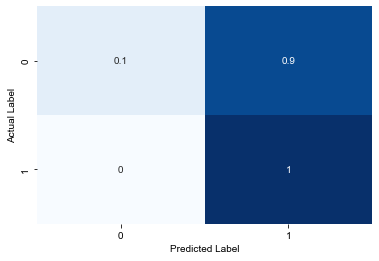

    0    1
0   0    0
1  11  101


c:\Users\David\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\David\AppData\Local\Temp\ipykernel_12156\2740489789.py:70: RuntimeWarning: invalid value encountered in true_divide
  normalized_matrix = np.round(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis],2)


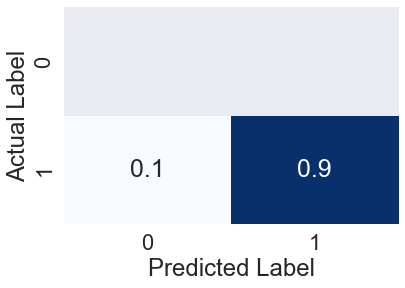

    0   1
0  26   0
1  74  52


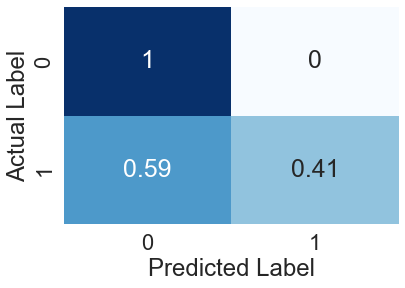

   0   1
0  6  52
1  0  77


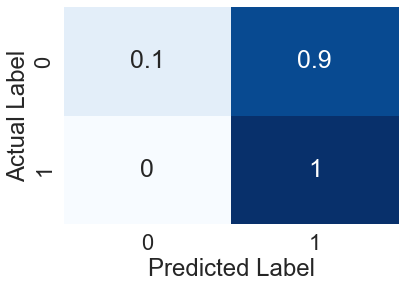

    0    1
0   0    0
1  11  101


c:\Users\David\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\David\AppData\Local\Temp\ipykernel_12156\2740489789.py:70: RuntimeWarning: invalid value encountered in true_divide
  normalized_matrix = np.round(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis],2)


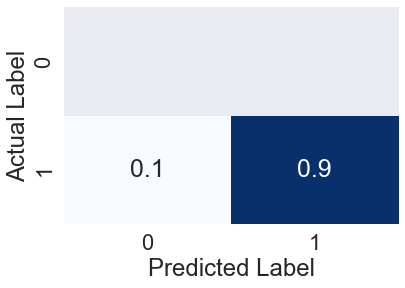

    0   1
0  26   0
1  74  52


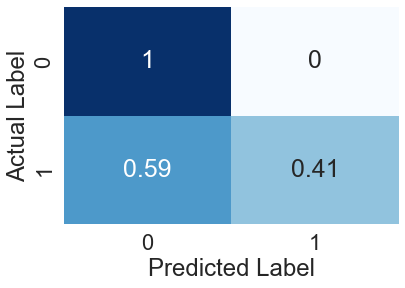

Total number of experiments: 6


,Balanced accuracy,Sensitivity,Specificity,F1,AUC,Accuracy
0,0.551724,1.000000,0.596899,0.747573,0.551724,0.614815
1,0.901786,0.901786,1.000000,0.948357,NaN,0.901786
2,0.706349,0.412698,1.000000,0.584270,0.706349,0.513158
3,0.551724,1.000000,0.596899,0.747573,0.551724,0.614815
4,0.901786,0.901786,1.000000,0.948357,NaN,0.901786
5,0.706349,0.412698,1.000000,0.584270,0.706349,0.513158


,Experiment,Balanced accuracy,Sensitivity,Specificity,F1,AUC,Accuracy,Metric
0,APZ++MM,0.72,0.77,0.87,0.76,0.63,0.68,Mean
0,APZ++MM,0.16,0.28,0.21,0.16,0.09,0.18,Std


In [19]:
# Preprocessing flags
FLAG_CROP = False                        # True, False
FLAG_TFUNC = True                       # True, False
FLAG_OVERSAMPLE = True                  # True, False
TRAIN_TEST_SPLIT_METHOD = 'sample'    # random, sampleID, sample

print('FLAG_OVERSAMPLE:',FLAG_OVERSAMPLE)
print('FLAG_CROP:',FLAG_CROP)
print('FLAG_TFUNC:',FLAG_TFUNC)
print('TRAIN_TEST_SPLIT_METHOD:',TRAIN_TEST_SPLIT_METHOD)

reduced_points = 100
number_trials = 6

experiments = []
# for exp in range(len(preprocessing_flags_list)):
for exp in range(1):
    # Preprocessing experiment flags
    FLAG_AMBIENT_LIGHT = preprocessing_flags_dict['FLAG_AMBIENT_LIGHT'][exp]
    FLAG_FEATURE_REDUCTION_METHOD = preprocessing_flags_dict['FLAG_FEATURE_REDUCTION_METHOD'][exp]
    FLAG_NORMALIZE = preprocessing_flags_dict['FLAG_NORMALIZE'][exp]

    FLAG_AMBIENT_LIGHT = 1 # None, 1, 2
    FLAG_FEATURE_REDUCTION_METHOD = 'None' # None, PCA, Binning
    FLAG_NORMALIZE = True # True, False

    # Print the current combination of preprocessing flags
    print('Ambient light: ', FLAG_AMBIENT_LIGHT, ', Feature reduction method: ', FLAG_FEATURE_REDUCTION_METHOD, ', Normalize: ', FLAG_NORMALIZE)

    # Preprocessing the data
    data_df = preprocessing_pipeline(Dataset_df,ambient_baseline_df, lightsource_output_curve,FLAG_AMBIENT_LIGHT,FLAG_CROP, FLAG_NORMALIZE, FLAG_TFUNC)

    experiment_results = []
    if TRAIN_TEST_SPLIT_METHOD == 'random':
            count = 0
            for i in range(1,number_trials+1):
                count = count + 1
                train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=i)
                train_df.reset_index(drop=True, inplace=True)
                test_df.reset_index(drop=True, inplace=True)
                # Feature reduction and classification
                results_df = feature_reduction(train_df,test_df,FLAG_FEATURE_REDUCTION_METHOD,reduced_points,CM_FLAG = False)
                experiment_results.append(results_df)        
    elif TRAIN_TEST_SPLIT_METHOD == 'sample':
        count = 0
        for idx in range(int(number_trials/3)):
            # Get the unique Sample Numbers
            unique_ids = data_df['Sample Number'].unique()
            # Perform a train test split based on sample number
            for i in range(len(unique_ids)):
                count = count + 1
                # print("Test set is sample number:",unique_ids[i])
                # get the train samples
                train_df = data_df[data_df['Sample Number'] != unique_ids[i]].reset_index(drop=True)
                # get the test sample
                test_df = data_df[data_df['Sample Number'] == unique_ids[i]].reset_index(drop=True)
                results_df = feature_reduction(train_df,test_df,FLAG_FEATURE_REDUCTION_METHOD, reduced_points,CM_FLAG=True)
                experiment_results.append(results_df)
    elif TRAIN_TEST_SPLIT_METHOD == 'sampleID':
        count = 0
        for idx in range(int(number_trials/6)):
            # Get the unique sample IDs
            unique_ids = data_df['SampleID'].unique()
            # Perform a train test split based on sampleID
            for i in range(len(unique_ids)):
                count = count + 1
                print("Test set is sample ID:",unique_ids[i])
                # get the test sample 
                test_df = data_df[data_df['SampleID'] == unique_ids[i]].reset_index(drop=True)
                # get the train samples
                train_df = data_df[data_df['SampleID'] != unique_ids[i]].reset_index(drop=True)
                results_df = feature_reduction(train_df,test_df,FLAG_FEATURE_REDUCTION_METHOD, reduced_points, CM_FLAG=True)
                experiment_results.append(results_df)
    print('Total number of experiments:',count)

    # concatenate all of the results
    results = pd.concat(experiment_results).reset_index(drop=True)
    if TRAIN_TEST_SPLIT_METHOD != 'random':
        display(results)
        pass
    # Get the average and standard deviation of each column
    results_df_mean = results.mean(axis=0).to_frame().T
    results_df_mean['Metric'] = 'Mean'  
    results_df_std = results.std(axis=0).to_frame().T
    results_df_std['Metric'] = 'Std'
    results = pd.concat([results_df_mean,results_df_std]).reset_index(drop=True)

    # Add the preprocessing flags to the results
    # ambient flag
    if FLAG_AMBIENT_LIGHT == 'None':
        exp_Ambient = ''
    elif FLAG_AMBIENT_LIGHT == 1:
        exp_Ambient = 'APZ'
    elif FLAG_AMBIENT_LIGHT == 2:
        exp_Ambient = 'ALE'
    # feature reduction flag
    if FLAG_FEATURE_REDUCTION_METHOD == 'None':
        exp_Feature = ''
    elif FLAG_FEATURE_REDUCTION_METHOD == 'PCA':
        exp_Feature = 'PCA'
    elif FLAG_FEATURE_REDUCTION_METHOD == 'Binning':
        exp_Feature = 'Bin'
    # normalize flag
    if FLAG_NORMALIZE == True:
        exp_MinMax = 'MM'
    elif FLAG_NORMALIZE == False:
        exp_MinMax = ''

    # create a column with the experiment name ambient light + feature reduction + normalize
    results['Experiment'] = exp_Ambient + '+' + exp_Feature + '+' + exp_MinMax

    desired_column_order = ['Experiment','Balanced accuracy','Sensitivity','Specificity','F1','AUC','Accuracy','Metric']

    results = results[desired_column_order]
    # set index to the experiment number
    results.index = [exp,exp]
    # display(results.round(2))
    experiments.append(results)

# concatenate all of the results
experiments_saved = pd.concat(experiments)
display(experiments_saved.round(2))

# # Save the experiments_saved df to a csv file
# path = 'C:/GithubProjects/Spectroscopy_TrackedTissueSensing/Thesis_results_4-4'
# filename = f'experiments_saved_{TRAIN_TEST_SPLIT_METHOD}.pkl'
# experiments_saved.to_pickle(f'{path}/{filename}')


In [20]:
# display(data_df.head())
unique_ids = data_df['Sample Number'].unique()
for i in unique_ids:
    x = data_df[data_df['Sample Number'] == i].reset_index(drop=True)
    # calculate the amount of cancerous and normal spectra
    cancerous = x[x['Label (numeric)'] == 1].shape[0]
    normal = x[x['Label (numeric)'] == 0].shape[0]
    print('Sample Number: ', i)
    print('Cancerous: ', cancerous)
    print('Normal: ', normal)
    
# display(x.head())


Sample Number:  1
Cancerous:  77
Normal:  58
Sample Number:  2
Cancerous:  112
Normal:  0
Sample Number:  3
Cancerous:  126
Normal:  26


In [21]:
# load the file back into a dataframe
path = 'C:/GithubProjects/Spectroscopy_TrackedTissueSensing/Thesis_results_4-4'
# ttm = 'sampleID' # random, sampleID, sample
ttm = TRAIN_TEST_SPLIT_METHOD
filename = f'experiments_saved_{ttm}.pkl'
experiments = pd.read_pickle(f'{path}/{filename}')
display(experiments)
# experiments.head()


,Experiment,Balanced accuracy,Sensitivity,Specificity,F1,AUC,Accuracy,Metric
0,++,0.713773,0.735119,0.864103,0.697473,0.575123,0.649054,Mean
0,++,0.201197,0.374599,0.195473,0.268901,0.032852,0.268413,Std
1,++MM,0.713773,0.735119,0.864103,0.697473,0.575123,0.649054,Mean
1,++MM,0.201197,0.374599,0.195473,0.268901,0.032852,0.268413,Std
2,+PCA+,0.703429,0.748247,0.861111,0.727470,0.593090,0.651181,Mean
2,+PCA+,0.168488,0.309539,0.199776,0.198296,0.069563,0.207092,Std
3,+PCA+MM,0.698227,0.741435,0.861260,0.722275,0.591537,0.645068,Mean
3,+PCA+MM,0.162978,0.310939,0.199564,0.199386,0.067083,0.203791,Std
4,+Bin+,0.732419,0.786676,0.858586,0.756875,0.598628,0.686014,Mean
4,+Bin+,0.205817,0.297551,0.203409,0.190804,0.090163,0.229419,Std


In [22]:
experiment_table_df = experiments.copy()
# make an empty data frame with the same headers
formatted_table = pd.DataFrame(index = experiment_table_df.index.unique(), columns=experiment_table_df.columns)
for index in range(experiment_table_df.index.nunique()) :
    rows = experiment_table_df.loc[index]
    # copy the first row into the formatted table
    formatted_table.loc[index] = rows.iloc[0]
    # Repeat for each column that contains numbers (i.e. not the index, or experiment name, etc.)
    columns = rows.columns
    for column_name in columns[1:-1]:
        # the mean is in the first row and the std is in the second row
        mean = int(rows[column_name].iloc[0] *100)
        std = float(rows[column_name].iloc[1]*100)
        # convert to a float with 2 decimal places
        std = int(round(std, 0))
        # combine them into a single string
        string = f"${mean} \pm {std}$"
        # put the string into the formatted table
        formatted_table.loc[index, column_name] = string
    # break
# formatted_table['Experiment'] = formatted_table['Experiment'].str.replace(r'\+(?![a-zA-Z])', '', regex=True)
formatted_table['Experiment'] = formatted_table['Experiment'].str.replace(r'^\+|\+$|\+(?!\w)', '', regex=True)

# display(formatted_table)

# update the names in the Experiment column
formatted_table.loc[:,'Experiment'] = ['Baseline', 'MinMax (MM)', 'PCA','PCA+MM',
                                     'Bin','RS+MM',
                                     'APZ', 'APZ+MM','PCA+APZ','PCA+APZ+MM','Bin+APZ','Bin+APZ+MM',
                                     'ALE', 'ALE+MM','PCA+ALE','PCA+ALE+MM','Bin+ALE','Bin+ALE+MM'
                                     ]
display(formatted_table)
# new_order = [0,12,6,1,2,4,13,7,3,8,9,14,15,5,10,11,16,17]
new_order = [0,12,6,1,2,4,13,7,15,9,17,11]


formatted_table = formatted_table.iloc[new_order]
display(formatted_table)
# display(formatted_table)
formatted_table = formatted_table.drop(columns=['Metric'])
formatted_table = formatted_table.rename(columns={'Balanced accuracy': 'BalAcc'})
formatted_table = formatted_table.rename(columns={'Accuracy': 'Acc'})
formatted_table = formatted_table.rename(columns={'Sensitivity': 'Sens'})
formatted_table = formatted_table.rename(columns={'Specificity': 'Spec'})

# Generate the latex table
caption_name = f"Results of the preprocessing experiment using a {TRAIN_TEST_SPLIT_METHOD}-based train-test split."
label_table = f"tab:results_{TRAIN_TEST_SPLIT_METHOD}"
latex_table = formatted_table.to_latex(index=False, column_format='|l|c|c|c|c|c|c|c|c|c|', float_format="%.2f", bold_rows=True, escape=False, caption=caption_name, label=label_table)

latex_table = latex_table.replace('\\toprule', '\\hline')
latex_table = latex_table.replace('\\midrule', '\\hline \hline')
latex_table = latex_table.replace('\\bottomrule', '\\hline')

# Bold the column names by adding \textbf{} around them
columns_to_bold = formatted_table.columns
for col in columns_to_bold:
    # print(col)
    latex_table = latex_table.replace(col, '\\textbf{' + col + '}')

print(latex_table)

,Experiment,Balanced accuracy,Sensitivity,Specificity,F1,AUC,Accuracy,Metric
0,Baseline,$71 \pm 20$,$73 \pm 37$,$86 \pm 20$,$69 \pm 27$,$57 \pm 3$,$64 \pm 27$,Mean
1,MinMax (MM),$71 \pm 20$,$73 \pm 37$,$86 \pm 20$,$69 \pm 27$,$57 \pm 3$,$64 \pm 27$,Mean
2,PCA,$70 \pm 17$,$74 \pm 31$,$86 \pm 20$,$72 \pm 20$,$59 \pm 7$,$65 \pm 21$,Mean
3,PCA+MM,$69 \pm 16$,$74 \pm 31$,$86 \pm 20$,$72 \pm 20$,$59 \pm 7$,$64 \pm 20$,Mean
4,Bin,$73 \pm 21$,$78 \pm 30$,$85 \pm 20$,$75 \pm 19$,$59 \pm 9$,$68 \pm 23$,Mean
5,RS+MM,$73 \pm 21$,$78 \pm 30$,$85 \pm 20$,$75 \pm 19$,$59 \pm 9$,$68 \pm 23$,Mean
6,APZ,$69 \pm 20$,$71 \pm 40$,$86 \pm 20$,$67 \pm 30$,$55 \pm 3$,$63 \pm 28$,Mean
7,APZ+MM,$69 \pm 20$,$71 \pm 39$,$86 \pm 20$,$67 \pm 30$,$55 \pm 3$,$62 \pm 28$,Mean
8,PCA+APZ,$69 \pm 14$,$73 \pm 29$,$86 \pm 20$,$72 \pm 18$,$60 \pm 7$,$64 \pm 18$,Mean
9,PCA+APZ+MM,$69 \pm 14$,$74 \pm 28$,$86 \pm 20$,$73 \pm 17$,$60 \pm 7$,$64 \pm 17$,Mean


,Experiment,Balanced accuracy,Sensitivity,Specificity,F1,AUC,Accuracy,Metric
0,Baseline,$71 \pm 20$,$73 \pm 37$,$86 \pm 20$,$69 \pm 27$,$57 \pm 3$,$64 \pm 27$,Mean
12,ALE,$71 \pm 19$,$75 \pm 33$,$86 \pm 20$,$72 \pm 22$,$58 \pm 6$,$66 \pm 23$,Mean
6,APZ,$69 \pm 20$,$71 \pm 40$,$86 \pm 20$,$67 \pm 30$,$55 \pm 3$,$63 \pm 28$,Mean
1,MinMax (MM),$71 \pm 20$,$73 \pm 37$,$86 \pm 20$,$69 \pm 27$,$57 \pm 3$,$64 \pm 27$,Mean
2,PCA,$70 \pm 17$,$74 \pm 31$,$86 \pm 20$,$72 \pm 20$,$59 \pm 7$,$65 \pm 21$,Mean
4,Bin,$73 \pm 21$,$78 \pm 30$,$85 \pm 20$,$75 \pm 19$,$59 \pm 9$,$68 \pm 23$,Mean
13,ALE+MM,$72 \pm 17$,$75 \pm 32$,$86 \pm 19$,$73 \pm 21$,$60 \pm 5$,$66 \pm 22$,Mean
7,APZ+MM,$69 \pm 20$,$71 \pm 39$,$86 \pm 20$,$67 \pm 30$,$55 \pm 3$,$62 \pm 28$,Mean
15,PCA+ALE+MM,$65 \pm 9$,$70 \pm 28$,$86 \pm 20$,$70 \pm 15$,$60 \pm 7$,$60 \pm 13$,Mean
9,PCA+APZ+MM,$69 \pm 14$,$74 \pm 28$,$86 \pm 20$,$73 \pm 17$,$60 \pm 7$,$64 \pm 17$,Mean


\begin{table}
\caption{Results of the preprocessing experiment using a sample-based train-test split.}
\label{tab:results_sample}
\begin{tabular}{|l|c|c|c|c|c|c|c|c|c|}
\hline
\textbf{Experiment} & \textbf{Bal\textbf{Acc}} & \textbf{Sens} & \textbf{Spec} & \textbf{F1} & \textbf{AUC} & \textbf{Acc} \\
\hline \hline
Baseline & $71 \pm 20$ & $73 \pm 37$ & $86 \pm 20$ & $69 \pm 27$ & $57 \pm 3$ & $64 \pm 27$ \\
ALE & $71 \pm 19$ & $75 \pm 33$ & $86 \pm 20$ & $72 \pm 22$ & $58 \pm 6$ & $66 \pm 23$ \\
APZ & $69 \pm 20$ & $71 \pm 40$ & $86 \pm 20$ & $67 \pm 30$ & $55 \pm 3$ & $63 \pm 28$ \\
MinMax (MM) & $71 \pm 20$ & $73 \pm 37$ & $86 \pm 20$ & $69 \pm 27$ & $57 \pm 3$ & $64 \pm 27$ \\
PCA & $70 \pm 17$ & $74 \pm 31$ & $86 \pm 20$ & $72 \pm 20$ & $59 \pm 7$ & $65 \pm 21$ \\
Bin & $73 \pm 21$ & $78 \pm 30$ & $85 \pm 20$ & $75 \pm 19$ & $59 \pm 9$ & $68 \pm 23$ \\
ALE+MM & $72 \pm 17$ & $75 \pm 32$ & $86 \pm 19$ & $73 \pm 21$ & $60 \pm 5$ & $66 \pm 22$ \\
APZ+MM & $69 \pm 20$ & $71 \pm 39$ & $